## SVC klasifikatorius

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

# Įkeliame duomenis iš pateikto failo
data = pd.read_csv('data_visi_v2.csv')

# Kategorijų kūrimas pagal kuro sąnaudas
bins = [0, 5000, 15000, float('inf')]
labels = ['Low', 'Medium', 'HIGH']
data['DIDUMAS'] = pd.cut(data['KIEKIS'], bins=bins, labels=labels)

# Pasiruošiame duomenis (be 'mpg' stulpelio)
X = data.drop(columns=['KIEKIS', 'DIDUMAS'])
y = data['DIDUMAS']

# Padalijame į treniravimo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sukuriame polinominius požymius
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Normalizuojame duomenis
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Sukuriame SVM klasifikatorių
svm_classifier = SVC()

# Nustatome hiperparametrų tinklą
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}


In [2]:
# Naudojame GridSearchCV geriausiems parametrams rasti
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_poly_scaled, y_train)

# Geriausi parametrai
best_params = grid_search.best_params_

# Geriausias modelis
best_model = grid_search.best_estimator_

# Atliekame prognozes su geriausiu modeliu
y_train_pred = best_model.predict(X_train_poly_scaled)
y_test_pred = best_model.predict(X_test_poly_scaled)

# Vertiname modelį
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Kryžminė validacija su pilnu duomenų rinkiniu
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])
X_combined_poly = poly.fit_transform(X_combined)
X_combined_poly_scaled = scaler.fit_transform(X_combined_poly)

cv_scores_5 = cross_val_score(best_model, X_combined_poly_scaled, y_combined, cv=5, scoring='accuracy')
cv_scores_10 = cross_val_score(best_model, X_combined_poly_scaled, y_combined, cv=10, scoring='accuracy')

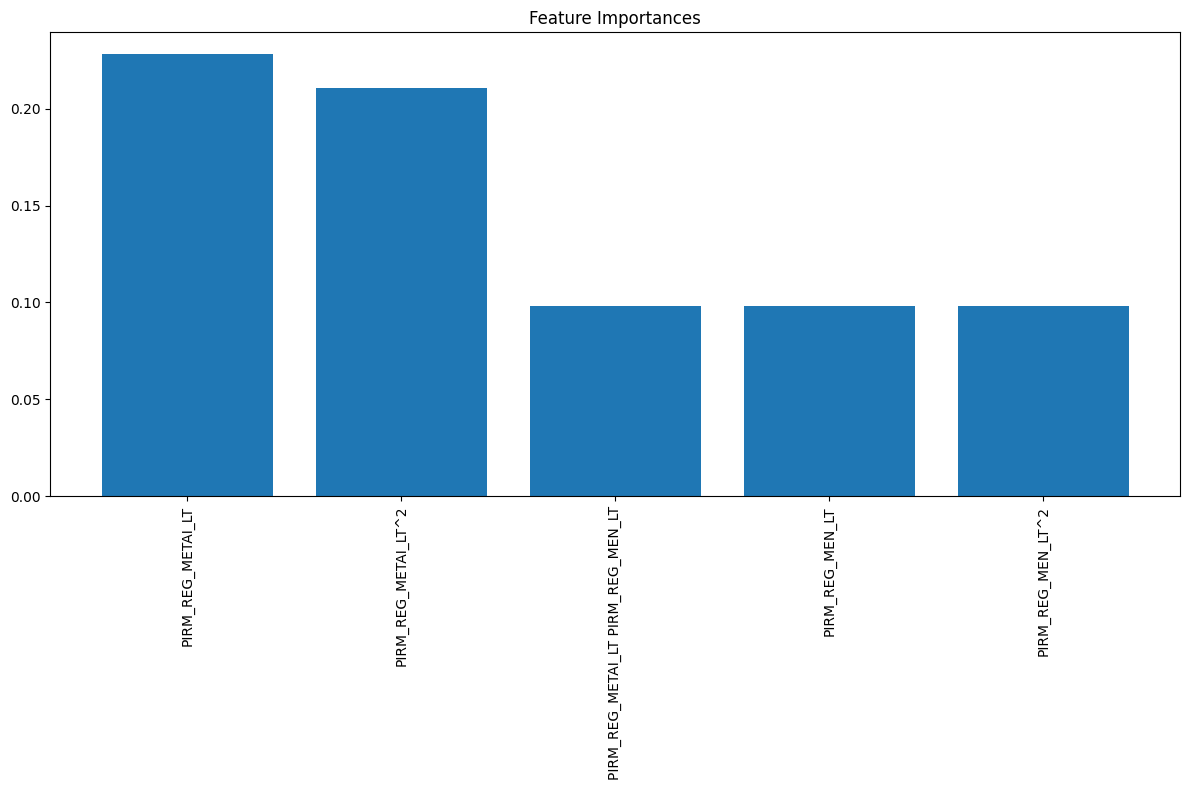

Geriausi parametrai: {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}
Treniravimo tikslumas: 0.8482142857142857
Testavimo tikslumas: 0.7894736842105263
Kryžminės validacijos (cv=5) tikslumo reikšmės: [0.77192982 0.76785714 0.89285714 0.92857143 0.78571429]
Kryžminės validacijos (cv=5) vidutinis tikslumas: 0.8293859649122807
Kryžminės validacijos (cv=10) tikslumo reikšmės: [0.79310345 0.85714286 0.75       0.82142857 0.92857143 0.75
 0.96428571 0.92857143 0.82142857 0.67857143]
Kryžminės validacijos (cv=10) vidutinis tikslumas: 0.8293103448275861


In [3]:
# Požymių svarbos vertinimas
result = permutation_importance(best_model, X_test_poly_scaled, y_test, n_repeats=10, random_state=42)
# n_repeats =  kiek kartų atsitiktinai pakeisti duomenų tvarką ar eiliškumą.
importance = result.importances_mean

# Požymių svarbos vizualizacija
features = poly.get_feature_names_out()
indices = np.argsort(importance)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_test_poly.shape[1]), importance[indices], align="center")
plt.xticks(range(X_test_poly.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

# Rezultatų spausdinimas
print(f'Geriausi parametrai: {best_params}')
print(f'Treniravimo tikslumas: {train_accuracy}')
print(f'Testavimo tikslumas: {test_accuracy}')

print(f'Kryžminės validacijos (cv=5) tikslumo reikšmės: {cv_scores_5}')
print(f'Kryžminės validacijos (cv=5) vidutinis tikslumas: {cv_scores_5.mean()}')

print(f'Kryžminės validacijos (cv=10) tikslumo reikšmės: {cv_scores_10}')
print(f'Kryžminės validacijos (cv=10) vidutinis tikslumas: {cv_scores_10.mean()}')